### 10. This exercise focuses on the brain tumor data, which is included in the ISLP library.

In [80]:
import numpy as np
import pandas as pd
from ISLP import load_data

In [81]:
df = load_data('BrainCancer')
df

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30
...,...,...,...,...,...,...,...,...
83,Male,HG glioma,Supratentorial,80,0.16,SRT,1,20.69
84,Male,HG glioma,Supratentorial,80,19.81,SRT,1,6.39
85,Male,Meningioma,Supratentorial,90,2.50,SRT,0,32.82
86,Male,Meningioma,Supratentorial,90,2.02,SRS,0,42.07


In [82]:
df_clean = pd.get_dummies(df, drop_first=True).dropna()
df_clean

,ki,gtv,status,time,sex_Male,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Supratentorial,stereo_SRT
0,90,6.11,0,57.64,0,0,1,0,0,0
1,90,19.35,1,8.98,1,0,0,0,1,1
2,70,7.95,0,26.46,0,0,1,0,0,0
3,80,7.61,1,47.80,0,1,0,0,1,1
4,90,5.06,1,6.30,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
83,80,0.16,1,20.69,1,0,0,0,1,1
84,80,19.81,1,6.39,1,0,0,0,1,1
85,90,2.50,0,32.82,1,0,1,0,1,1
86,90,2.02,0,42.07,1,0,1,0,1,0


##### (a) Plot the Kaplan-Meier survival curve with ±1 standard error bands, using the KaplanMeierFitter() estimator in the lifelines package.

<Axes: xlabel='timeline'>

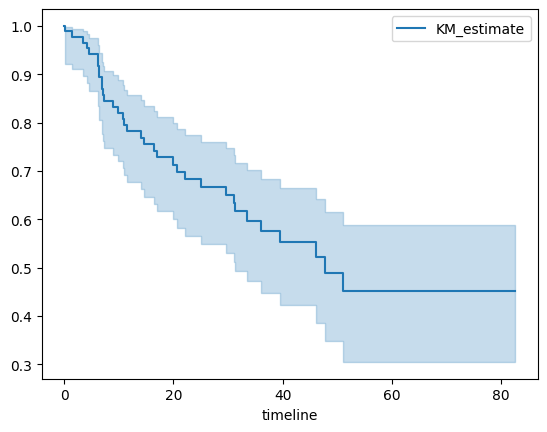

In [83]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(df_clean['time'], df_clean['status'])
kmf.plot()

##### (b) Draw a bootstrap sample of size n = 88 from the pairs (yi, δi), and compute the resulting Kaplan-Meier survival curve. Repeat this process B = 200 times. Use the results to obtain an estimate of the standard error of the Kaplan-Meier survival curve at each timepoint. Compare this to the standard errors obtained in (a).

In [84]:
B = 200
n = 88

bootstrap_samples = np.empty((B, n))

for i in range(B):
    bootstrap_sample_indices = np.random.choice(df.shape[0], size=n, replace=True)
    bootstrap_sample = df.iloc[bootstrap_sample_indices]
    
    kmf_bootstrap = KaplanMeierFitter()
    kmf_bootstrap.fit(bootstrap_sample['time'], bootstrap_sample['status'])
    
    bootstrap_samples[i, :] = kmf_bootstrap.survival_function_at_times(df['time']).values

standard_errors_bootstrap = np.std(bootstrap_samples, axis=0).mean()

print(f'Bootstrap SE: {standard_errors_bootstrap}')
print(f'Original Model SE: {kmf.alpha}')

Bootstrap SE: 0.04868046841482987
Original Model SE: 0.05


##### (c) Fit a Cox proportional hazards model that uses all of the predictors to predict survival. Summarize the main fndings.

In [85]:
from lifelines import CoxPHFitter
model = CoxPHFitter().fit(df_clean, 'time', 'status')
model.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
ki,-0.057920,0.018313,0.001563
gtv,0.036041,0.022623,0.111125
sex_Male,0.097854,0.360701,0.786169
diagnosis_LG glioma,-1.091266,0.573943,0.057256
diagnosis_Meningioma,-2.082012,0.453688,0.000004
diagnosis_Other,-1.235849,0.625866,0.048311
loc_Supratentorial,0.375835,0.697787,0.590156
stereo_SRT,0.139636,0.598031,0.815379


##### (d) Stratify the data by the value of ki. (Since only one observation has ki==40, you can group that observation together with the observations that have ki==60.) Plot Kaplan-Meier survival curves for each of the five strata, adjusted for the other predictors.

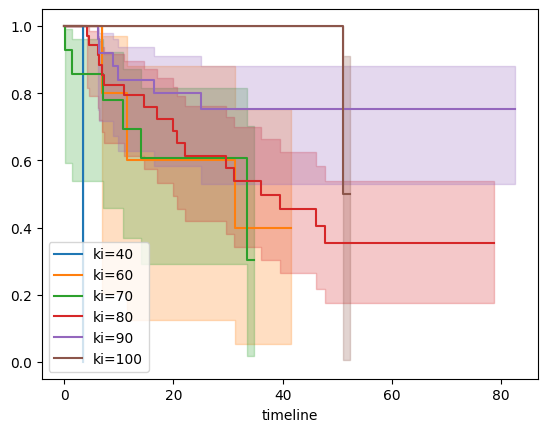

In [90]:
for idx, data in df.groupby('ki'):
    kmf.fit(data['time'], data['status'])
    kmf.plot(label=f'ki={idx}')